## Algoritmo A*
O **A*** é um algoritmo de busca informada que utiliza uma função heurística para encontrar o caminho ótimo. Ele combina:
- **g(n)**: custo real do caminho do início até o nó atual
- **h(n)**: estimativa heurística do custo do nó atual até o objetivo
- **f(n) = g(n) + h(n)**: função de avaliação total

A heurística deve ser **admissível** (nunca superestimar o custo real) para garantir a otimalidade da solução.

In [14]:
# Importação das bibliotecas necessárias
import heapq                 # Para fila de prioridade
import networkx as nx        # Para manipulação de grafos
import time                  # Para medição de tempo
from math import ceil        # Para arredondamento para cima
import matplotlib.pyplot as plt  # Para visualização
import os                    # Para manipulação de diretórios

In [15]:
# Carregamento do grafo e definição dos tempos de travessia
grafo = nx.read_graphml("grafo_ponte_tocha.graphml")
tempos_travessia = {'A': 1, 'B': 2, 'C': 5, 'D': 10}

In [16]:
def analisar_estado(no_str: str):
    """
    Converte uma string de nó do GraphML em uma tupla de estado.
    
    Args:
        no_str (str): String do nó no formato "inicio=ABCD|tocha=inicio"
    
    Returns:
        tuple: (frozenset das pessoas no início, posição da tocha)
        
    Example:
        "inicio=ABCD|tocha=inicio" -> (frozenset({'A','B','C','D'}), 'inicio')
    """
    esquerda, direita = no_str.split("|")
    pessoas_str = esquerda.split("=")[1].strip()
    posicao_tocha = direita.split("=")[1].strip()

    if pessoas_str == "VAZIO":
        pessoas = frozenset()
    else:
        pessoas = frozenset(list(pessoas_str))

    return pessoas, posicao_tocha

In [17]:
def busca_a_estrela(grafo: nx.DiGraph, inicio: str, objetivo: str, heuristica):
    """
    Implementação do algoritmo A* para grafos NetworkX.
    
    Args:
        grafo (nx.DiGraph): Grafo direcionado do NetworkX
        inicio (str): Nó inicial
        objetivo (str): Nó objetivo
        heuristica (function): Função heurística h(nó)
    
    Returns:
        tuple: (caminho, custo_total, arestas_exploradas, valores_nos) 
               ou (None, inf, arestas_exploradas, valores_nos) se não houver solução
    """
    # Fila de prioridade: (f, g, caminho)
    fila_prioridade = []
    valor_h_inicio = heuristica(analisar_estado(inicio))
    heapq.heappush(fila_prioridade, (valor_h_inicio, 0, [inicio]))

    # Custos acumulados conhecidos
    custo_g = {inicio: 0}
    arestas_exploradas = []  # Lista de (u, v) para visualização
    valores_nos = {}         # Dict[nó] = {"g": ..., "h": ..., "f": ...}

    valores_nos[inicio] = {"g": 0, "h": valor_h_inicio, "f": valor_h_inicio}

    while fila_prioridade:
        valor_f, valor_g, caminho = heapq.heappop(fila_prioridade)
        no_atual = caminho[-1]

        # Verifica se atingiu o objetivo
        if no_atual == objetivo:
            return caminho, valor_g, arestas_exploradas, valores_nos

        # Expande vizinhos
        for vizinho in grafo.neighbors(no_atual):
            # Custo da aresta
            custo_aresta = grafo[no_atual][vizinho].get("weight")
            novo_g = valor_g + custo_aresta

            # Salva aresta explorada para visualização
            arestas_exploradas.append((no_atual, vizinho))

            if vizinho not in custo_g or novo_g < custo_g[vizinho]:
                custo_g[vizinho] = novo_g
                valor_h = heuristica(analisar_estado(vizinho))
                novo_f = novo_g + valor_h
                valores_nos[vizinho] = {"g": novo_g, "h": valor_h, "f": novo_f}
                novo_caminho = caminho + [vizinho]
                heapq.heappush(fila_prioridade, (novo_f, novo_g, novo_caminho))

    return None, float("inf"), arestas_exploradas, valores_nos


def funcao_heuristica(estado):
    """
    Heurística admissível para o problema da Ponte e Tocha.
    
    Args:
        estado (tuple): (frozenset de pessoas no início, posição da tocha)
    
    Returns:
        int: Estimativa heurística do custo restante
    """
    pessoas_inicio, _ = estado
    qtd_pessoas = len(pessoas_inicio)
    
    if qtd_pessoas == 0:
        return 0

    # Tempo da pessoa mais lenta que ainda precisa atravessar
    tempo_mais_lento = max(tempos_travessia[p] for p in pessoas_inicio)
    
    # Tempo da pessoa mais rápida (para retornos)
    tempo_mais_rapido = min(tempos_travessia.values())

    # Número mínimo de travessias para frente necessárias
    travessias_necessarias = ceil(qtd_pessoas / 2)
    
    # Número mínimo de retornos necessários
    retornos_minimos = max(0, travessias_necessarias - 1)
    
    # Estimativa do tempo total dos retornos
    tempo_estimado_retornos = retornos_minimos * tempo_mais_rapido

    return max(tempo_mais_lento, tempo_estimado_retornos)

In [18]:
# Execução do algoritmo A*
tempo_inicio = time.time()

# Estados inicial e objetivo
estado_inicial = "inicio=ABCD|tocha=inicio"
estado_objetivo = "inicio=VAZIO|tocha=final"

# Verifica se os estados existem no grafo
if estado_inicial not in grafo or estado_objetivo not in grafo:
    raise ValueError("Estado inicial ou objetivo não encontrado no grafo.")

# Executa o algoritmo A*
caminho_final, custo_final, arestas_exploradas, valores_nos = busca_a_estrela(
    grafo=grafo, 
    inicio=estado_inicial, 
    objetivo=estado_objetivo, 
    heuristica=funcao_heuristica
)

tempo_fim = time.time()
duracao = tempo_fim - tempo_inicio

# Exibe os resultados
print(f"Caminho encontrado: {caminho_final}")
print(f"Custo total: {custo_final}")
print(f"Tempo de execução: {duracao:.6f} segundos")

print("\nArestas exploradas com valores dos nós:")
for origem, destino in arestas_exploradas:
    valores = valores_nos.get(destino, {"g": "-", "h": "-", "f": "-"})
    print(f"{origem} -> {destino} | g={valores['g']}, h={valores['h']}, f={valores['f']}")

Caminho encontrado: ['inicio=ABCD|tocha=inicio', 'inicio=CD|tocha=final', 'inicio=ACD|tocha=inicio', 'inicio=A|tocha=final', 'inicio=AB|tocha=inicio', 'inicio=VAZIO|tocha=final']
Custo total: 17
Tempo de execução: 0.000380 segundos

Arestas exploradas com valores dos nós:
inicio=ABCD|tocha=inicio -> inicio=AB|tocha=final | g=10, h=2, f=12
inicio=ABCD|tocha=inicio -> inicio=BC|tocha=final | g=10, h=5, f=15
inicio=ABCD|tocha=inicio -> inicio=AC|tocha=final | g=10, h=5, f=15
inicio=ABCD|tocha=inicio -> inicio=BD|tocha=final | g=5, h=10, f=15
inicio=ABCD|tocha=inicio -> inicio=AD|tocha=final | g=5, h=10, f=15
inicio=ABCD|tocha=inicio -> inicio=CD|tocha=final | g=2, h=10, f=12
inicio=CD|tocha=final -> inicio=ACD|tocha=inicio | g=3, h=10, f=13
inicio=CD|tocha=final -> inicio=BCD|tocha=inicio | g=4, h=10, f=14
inicio=AB|tocha=final -> inicio=ABD|tocha=inicio | g=6, h=10, f=16
inicio=AB|tocha=final -> inicio=ABC|tocha=inicio | g=11, h=5, f=16
inicio=ACD|tocha=inicio -> inicio=C|tocha=final | g

Imagem da exploração A* salva em: imagens/a_star_exploracao.png


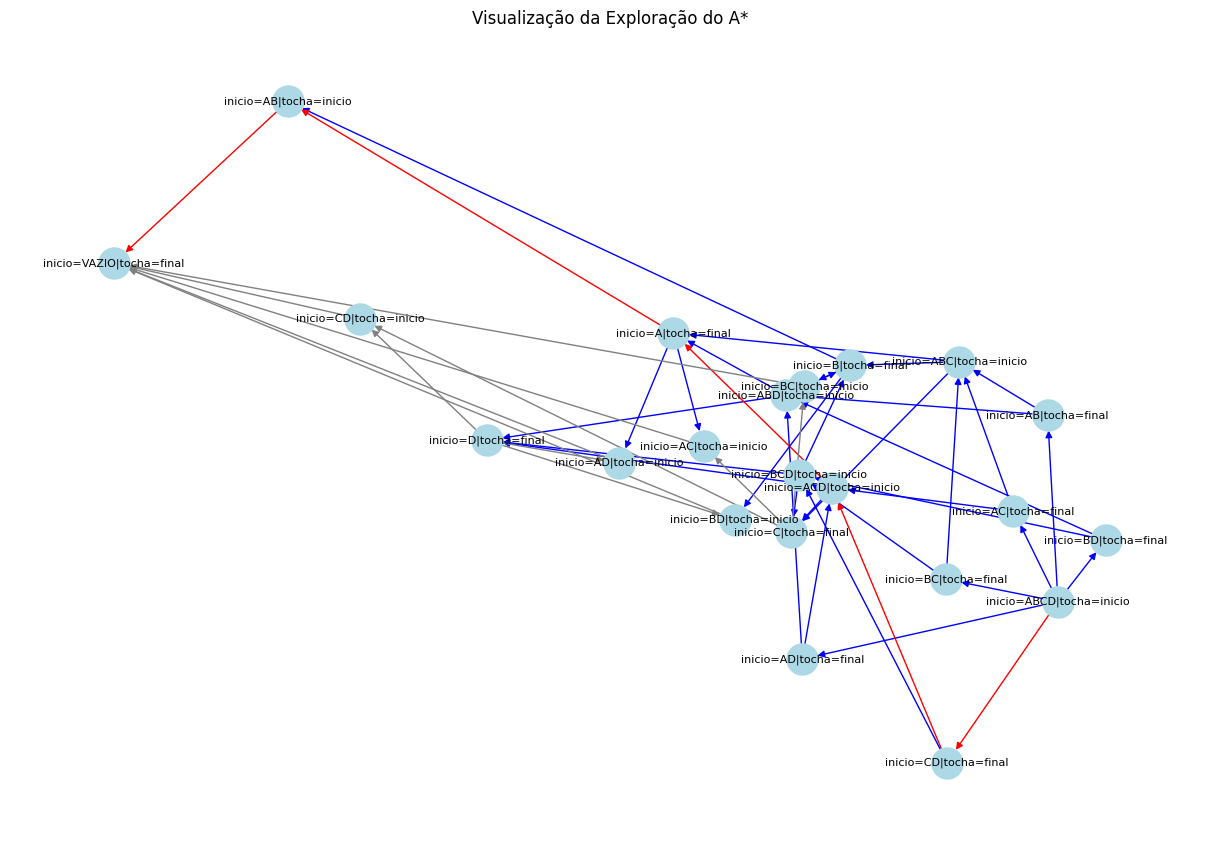

In [19]:
def visualizar_exploracao(grafo, arestas_exploradas, caminho_final, salvar_imagem=True):
    """
    Visualiza o grafo destacando as arestas exploradas e o caminho final.
    
    Args:
        grafo (nx.Graph): Grafo a ser visualizado
        arestas_exploradas (list): Lista de arestas exploradas durante a busca
        caminho_final (list): Sequência de nós do caminho ótimo encontrado
        salvar_imagem (bool): Se True, salva a imagem em arquivo
    """
    cores_arestas = []
    arestas_caminho = set(zip(caminho_final, caminho_final[1:]))

    # Define cores das arestas baseado no tipo
    for origem, destino in grafo.edges():
        if (origem, destino) in arestas_caminho:
            cores_arestas.append("red")      # Caminho final em vermelho
        elif (origem, destino) in arestas_exploradas:
            cores_arestas.append("blue")     # Arestas exploradas em cinza
        else:
            cores_arestas.append("gray") # Outras arestas em cinza claro

    # Cria o layout e desenha o grafo
    posicoes = nx.spring_layout(grafo, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw(
        grafo, 
        posicoes, 
        with_labels=True, 
        node_size=500,
        node_color="lightblue", 
        edge_color=cores_arestas, 
        arrows=True,
        font_size=8
    )
    
    plt.title("Visualização da Exploração do A*")
    
    # Salva a imagem se solicitado
    if salvar_imagem:
        if not os.path.exists('imagens'):
            os.makedirs('imagens')
        plt.savefig('imagens/a_star_exploracao.png', dpi=300, bbox_inches='tight')
        print("Imagem da exploração A* salva em: imagens/a_star_exploracao.png")
    
    plt.show()

# Visualiza o resultado
visualizar_exploracao(grafo, arestas_exploradas, caminho_final, salvar_imagem=True)